


<!-- PC NOTE: MAYBE DO SOME COMPUTATIONAL VALIDATION OF THE APPROXIMATION k_ik_j/2m? -->

# Degree-Preserving Random Graphs

Many properties of graphs are at least partially determined by the degree sequence of the graph. As we saw in [our discussion of centrality](04-centrality.qmd), for example, the centrality of a node is highly-correlated to its degree. As we'll see later in these notes, the degree sequence also plays a major role in determining whether, for example, an epidemic can spread on a network. On the other hand, not all properties of graphs are so constrained by the degree sequence. For example, when we studied the [structure of empirical networks](07-real-world.qmd), we saw that the density of triangles (as measured by the transitivity) varies strongly between real-world networks and their degree-preserving random counterparts.

So, which properties of a graph are controlled by the degree sequence? One way to approach this problem is to study models of random graphs in which the degree sequence is held constant, either exactly or approximately. In this set of notes, we'll introduce several such models and develop some of their properties.

## Fixing a Degree Sequence: The Configuration Model

In the configuration model, we choose a degree sequence. We then attempt to generate a random graph that has *exactly* that degree sequence.

::: {.callout-note icon=false appearance="minimal"}
::: {#def-config-model-sequence}

## Configuration Model

Consider a graph with $n$ nodes. Let ${\bf k} \in \mathbb{N}^n$ be the degree sequence, where $k_i$ is the degree of node $i$.

A **configuration model** is a uniform distribution over graphs with degree sequence ${\bf k}.$

:::
:::

It's not guaranteed that it is always possible to generate a graph with degree sequence $\mathbf{k}$.


::: {.callout-important icon=false appearance="minimal"}

## Exercise

Give a necessary condition on $\sum_{i = 1}^n k_i$ for it to be possible to form a graph with degree sequence $\mathbf{k}$.

:::

In fact, it is possible to give a complete characterization of the degree sequences $\mathbf{k}$ which can be realized as simple undirected graphs; this characterization is given by the [Erdős-Gallai theorem](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93Gallai_theorem) [@erdos1960graphs].

### Sampling From Configuration Models

It's surprisingly complicated to draw a sample from a configuration model random graph. We can draw *approximate* samples from the configuration model using the *stub-matching* algorithm.

In stub-matching, we create a list of "stubs," or half-edges. Each node $i$ with degree $k_i$ appears in this list $k_i$ times. We form edges by picking two stubs at a time out of the list and forming an edge between them. Let's implement this stub-matching algorithm. Before we do, we'll load in our favorite example graph and extract its degree sequence.

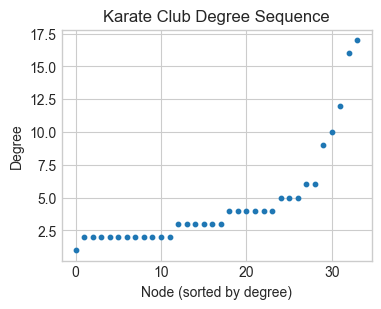

In [32]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plot_kwargs = {"node_size" : 100, "edgecolors" : 'white', "node_color" : "steelblue", "width" : 0.5, "edge_color" : "darkgrey"}


G_Karate = nx.karate_club_graph()
deg_seq = [k for n, k in G_Karate.degree()]
fig, ax = plt.subplots(1, 1, figsize = (4, 3))
ax.scatter(np.arange(0, len(deg_seq)), np.sort(deg_seq),  s = 10)
labs = ax.set(xlabel = "Node (sorted by degree)", ylabel = "Degree", title = "Karate Club Degree Sequence")

Now we'll implement an algorithm to perform stub-matching. First, we create the list of stubs. Each node appears a number of times equal to its degree.

In [22]:
stubs = np.repeat(np.arange(len(deg_seq)), deg_seq)

Now we need to take random pairs from this list of stubs. We could do this with a loop, but another way is to shuffle the list and then reshape it into a list of pairs:

In [23]:
mixed_stubs = np.random.permutation(stubs)
edge_list = mixed_stubs.reshape(len(mixed_stubs)//2, 2)

Now we can create a graph from our newly-constructed edge-list. Importantly, this graph might contain both self-loops and multi-edges, and so we need to use the `nx.MultiGraph` constructor.

In [24]:
G = nx.MultiGraph()
G.add_edges_from(edge_list)

G_k = [k for _, k in G.degree()]
print("Original degree sequence: ", sorted(deg_seq))
print("Generated degree sequence:", sorted(G_k))

Original degree sequence:  [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 9, 10, 12, 16, 17]
Generated degree sequence: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 9, 10, 12, 16, 17]


Here's how our random graph compares to our original:

[Text(0.5, 1.0, 'Configuration Model Graph')]

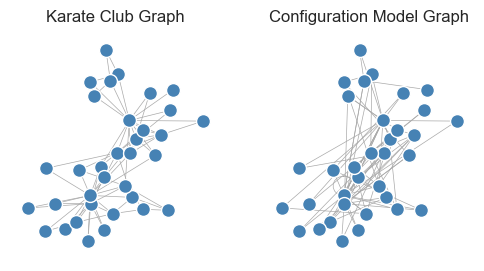

In [25]:
fig, axarr = plt.subplots(1, 2, figsize = (6, 3))
axarr[0].set(title = "Karate Club Graph")

pos = nx.spring_layout(G_Karate)

nx.draw(G_Karate, pos, ax = axarr[0], **plot_kwargs)

nx.draw(G, pos, ax = axarr[1], **plot_kwargs)
axarr[1].set(title = "Configuration Model Graph")

The stub-matching algorithm can produce multiedges and self-loops, which can cause the graph to not be simple. However, @bollobas1980probabilistic proved that, when the graph is sparse, the expected number of multi-edges and self-loops does not grow with network size. One can, as a result, show these structures are rare, and can often be ignored in arguments. In practical terms, we often discard the self-loops and multi-edges when constructing the graph; this results in the degree sequence no longer being *exactly* preserved, but the effect is u sually small.

@fosdick2018configuring discuss the subtleties that arise due to whether we allow or disallow multiedges and self-loops and whether we choose to label stubs distinctly (as opposed to only labeling vertices). These choices result in different spaces of graphs from which we are sampling. If we want to sample a simple graph from a configuration model with exactly the specified degree sequence, stub-matching is no longer sufficient. Instead, we need to rely on edge-rewiring algorithms, which randomly swap edges between nodes of the graph to randomize the graph while ensuring that the degrees of nodes remain constant. NetworkX implements a version of such an algorithm. The user needs to specify how many rewiring steps should be performed.

In [26]:
G = nx.Graph()
G.add_edges_from(edge_list)
G = nx.random_reference(G_Karate, connectivity=False, niter=100)

Here's how this looks:

[Text(0.5, 1.0, 'Configuration Model \nGraph (Rewiring)')]

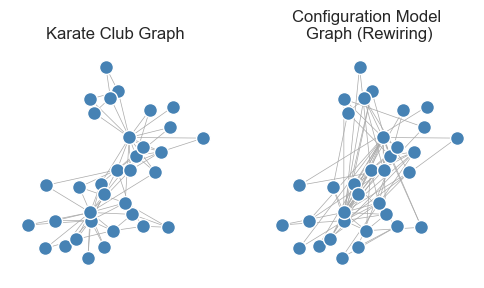

In [27]:
fig, axarr = plt.subplots(1, 2, figsize = (6, 3))
axarr[0].set(title = "Karate Club Graph")

nx.draw(G_Karate, pos, ax = axarr[0], **plot_kwargs)

nx.draw(G, pos, ax = axarr[1], **plot_kwargs)
axarr[1].set(title = "Configuration Model \nGraph (Rewiring)")

This algorithm is guaranteed not to produce multiedges  or self-loops and therefore exactly preserves the degree sequence. However, it can be much slower to generate random graphs this way, and it is difficult to know how many iterations are necessary to ensure that the resulting graph is "random enough." [Technically, the rewiring process creates a *Markov chain* on the space of graphs, and the question of whether the graph is "random enough" is a question about the *mixing time* of the Markov chain. ]{.aside}

## Expected Degree Sequences: The Chung--Lu Model

Some of the challenges with stub-matching arise from the requirement that we generate a graph with a specified degree sequence ${\bf k}.$ @chung2002connected relax this constraint and generate networks whose degree sequences are *approximately* ${\bf k}$ *in expectation*, which avoids some of these issues.

Suppose that we want to generate a graph with $n$ nodes where the degree of node $i$ is approximately equal to $k_i$. We'll again think with stubs: if node $i$ has degree $k_i$, then it has $k_i$ stubs. There are a total of $2m$ stubs, of which $k_i$ are already attached to $i$, so the number of stubs $i$ could attach to is $2m-k_i$. Of these, $k_j$ are attached to node $j$. So, the probability that a given stub of $i$ connects to node $j$ is approximately $k_j/(2m-k_i)$, and there are $k_i$ such stubs:
$$
    \mathbb{P}(\text{node $i$ stub connects to node $j$}) = \frac{k_j}{2m-k_i} \approx \frac{k_ik_j}{2m}
$$

assuming that $k_i$ and $k_j$ are small compared to $2m$. Summing over all $k_i$ stubs, we have

$$
\begin{aligned}
    \mathbb{E}[\text{number of edges between $i$ and $j$}] &\approx \frac{k_ik_j}{2m} \,.
\end{aligned}
$$

So, we can place down a Poisson-distributed number of edges between $i$ and $j$ with mean $k_ik_j/2m$. When $k_ik_j \ll 2m$, this is very similar to placing down a single edge with probability $k_ik_j/2m$; the probability of placing down two or more edges becomes very small.

We might notice that this feels a little similar to the $G(n,p)$ model, and in fact, this is by construction. The degree of node $i$ will be Poisson distributed with mean $k_i$ under the assumptions given above. [Another assumption required here is that the maximum degree is not too large in comparison to $n$.]{.aside} This means that, instead of stub-matching, we can use an algorithm like for a $G(n,p)$ network by placing an edge between two nodes with probability $P_{ij} = \frac{k_ik_j}{2m}$.

Here's a simple implementation of the Chung-Lu model.

Original degree sequence:  [16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]
Generated degree sequence: [16, 8, 13, 5, 4, 3, 2, 5, 9, 2, 2, 3, 1, 3, 6, 12, 13, 5, 11, 4, 2, 4, 1, 3, 4, 6, 5, 2, 1, 2, 2, 1]


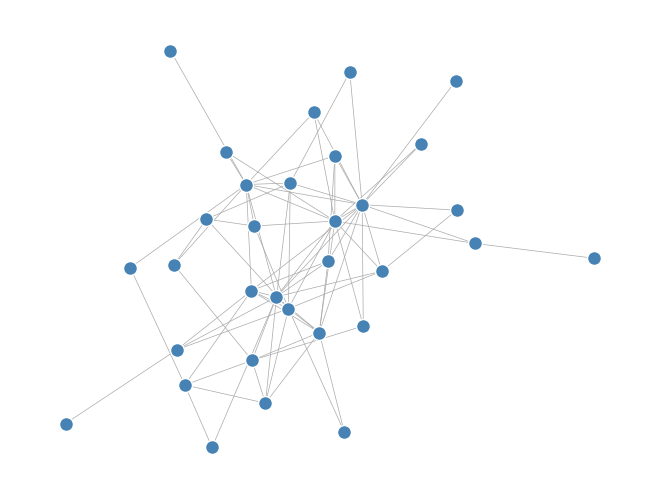

In [ ]:
from itertools import combinations

def ChungLu(deg_seq):
    edges = []
    for i, j in combinations(range(len(deg_seq)), 2):
            k_i = deg_seq[i]
            k_j = deg_seq[j]
            p = k_i * k_j / (2 * (sum(deg_seq)/2))

            if np.random.rand() < p:
                edges.append((i, j))

    G = nx.Graph()
    G.add_edges_from(edges)
    return G

G = ChungLu(deg_seq)
G_k = [k for _, k in G.degree()]
print("Original degree sequence: ", deg_seq)
print("Generated degree sequence:", G_k)

pos = nx.spring_layout(G)
nx.draw(G, pos, **plot_kwargs)

NetworkXError: Node 18 has no position.

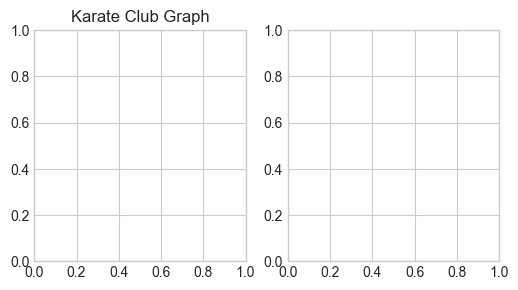

In [44]:
fig, axarr = plt.subplots(1, 2, figsize = (6, 3))
axarr[0].set(title = "Karate Club Graph")

nx.draw(G_Karate, pos, ax = axarr[0], **plot_kwargs)

nx.draw(G, pos, ax = axarr[1], **plot_kwargs)
axarr[1].set(title = "Chung-Lu Model \nGraph")

We can compare the degree sequence of the random graph we constructed to that of the original graph:

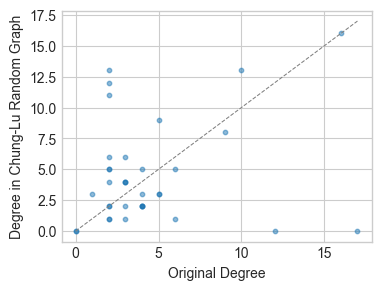

In [45]:
chung_lu_deg_seq = [k for n, k in G.degree()]

chung_lu_deg_seq = np.array(chung_lu_deg_seq)
chung_lu_deg_seq = np.concatenate((chung_lu_deg_seq, np.zeros(len(deg_seq) - len(G_k))))

fig, ax = plt.subplots(1, 1, figsize = (4, 3))
plt.plot([0, 17], [0, 17], color = "grey", linestyle = "--", linewidth = 0.75)
ax.scatter(deg_seq, chung_lu_deg_seq,  s = 10, label = "Karate Club", alpha = 0.5)
t = ax.set(xlabel = "Original Degree", ylabel = "Degree in Chung-Lu Random Graph")

[Text(0.5, 1.0, 'Node label'),
 Text(0.5, 0, 'Node'),
 Text(0, 0.5, 'Correction in Chung Lu Expectation (% error)')]

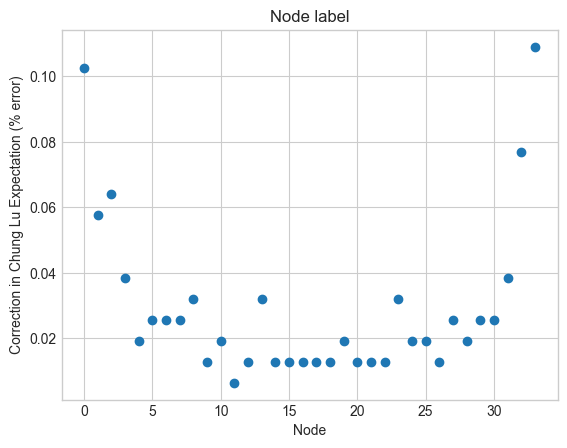

In [ ]:
k = np.array(deg_seq)

errors = (k)/(k.sum()) #(k**2)/(k.sum())

plt.scatter(np.arange(len(k)), errors)
plt.gca().set(title = "Node label", xlabel = "Node", ylabel = "Correction in Chung Lu Expectation (% error)")

We observe that the degrees in the Chung-Lu model are correlated with but not exactly equal to the original degrees. We notice that the nodes with high degrees in the original graph tend to have lower degree in the Chung-Lu model; this is expected as shown in the following exercise.

::: {.callout-important}

## Exercise

Show that the expected degree $\mathbb{E}[K_i]$ of node $i$ in the Chung-Lu model is equal to $k_i - \frac{k_i^2}{2m}$.

:::

## Fixed Degree Distributions

When making mathematical arguments, you may want to consider a "general graph with degree distribution $p_k$." That is, we're interested in a graph in which proportion $p_k$ of all nodes have degree $k$. This is a more flexible approach than specifying the degree $k_i$ of each individual node in a graph via the degree sequence $\mathbf{k}_i$.

We can do this using a slight modification to the strategy described above.

1. Draw a degree sequence $\{k_i\}$ from the given distribution $p_k.$
    - In practice, this is most likely achieved by $n$ independent draws from $p_k$. A particular degree sequence then appears with probability $\Pi_i p_{k_i}.$
2. Construct a graph with this degree sequence either exactly (configuration model) or approximately and in expectation (Chung-Lu) as described above.

Once again, we can easily run into some challenges here. With the algorithm described above it is very possible to generate a degree sequence with an odd number of stubs, and such degree sequences would need to be discarded. The concerns about self-edges, multiedges, and labeling that apply to the configuration model and Chung-Lu models still apply here.

While the two models we describe here are different, we expect them to behave similarly in the large-$n$ limit, where a sequence drawn from a degree distribution more accurately captures the underlying distribution. This approximation is justifiable using formal asymptotic reasoning when $n$ grows large and the degree distribution $p_k$ has variance that doesn't grow too rapidly with $n$.

There are some important special cases that we've already encountered:

- Using a Poisson degree distribution approximately recovers the $G(n,p)$ model, excepting that we are able to generate self- and multiedges with this configuration model variant.
- Using a power-law degree distribution helps us mathematically study the properties of scale-free networks, like those generated by preferential attachment.

With this approximation scheme, we can go on to study one of the most important properties of random graphs: the excess degree distribution.

## Excess Degree Distribution

Consider a configuration model with degree distribution $p_k$ (so a fraction $p_k$ of nodes have degree $k$). This means that $p_k$ can be viewed as the probability that a node chosen uniformly at random from our network has degree $k$. We'll let $n_k = np_k$ be the expected number of nodes of degree $k$.

Now, suppose we choose a node uniformly at random and follow an edges to this node's neighbor (if it has one). What is the probability that the neighbor will have degree $k$?

::: {.callout-warning}

## Exercise

Explain why the probability that the neighbor has degree $k$ is **not** also $p_k$.

:::

::: {.hide .solution}

Note that using this process, we are only able to select nodes that have neighbors. This is not necessarily all of our nodes in the graph! For example, the probability of selecting a node uniformly at random with degree 0 is $p_0$, but the probability that a neighbor of a node has degree 0 is 0.

:::

We'll again reason using stubs. First, let's calculate the probability that we have a stub connected to a particular degree $k$ node. A node with degree $k$ has $k$ stubs, and there are $2m-1$ possible stubs other than the one we selected. So,

$$
\begin{aligned}
    \mathbb{P}(\text{edge ends at particular degree $k$ node}) = \frac{k}{2m-1} \,.
\end{aligned}
$$

Thus, because in expectation there are $np_k$ nodes of degree $k$, we have

$$
\begin{align}
    \mathbb{P}(\text{edge ends at any degree $k$ node}) = \frac{k}{2m-1}n p_k \approx \frac{k}{2m}np_k \,.
\end{align}
$$

Let $\langle  k \rangle = \frac{1}{n} \sum_{i = 1}^n$ be the mean degree. Then, we must have that $\langle  k \rangle = \frac{2m}{n}$, so the probability that we reach a node of degree $k$ is approximately $\frac{1}{\langle k \rangle}k p_k.$ In other words, this probability is proportional to $kp_k$ (not $p_k$ as we might expect). This quantity is called the **edge-biased degree distribution.**

We can calculate the additional number of edges attached to a neighbor *other* than the edge we arrived along. For a node to have $k$ additional neighbors, it must have degree $k+1$. So, the probability that a neighbor has degree $k+1$ is
$$
\begin{align}
    q_k = \frac{(k+1)p_{k+1}}{\langle k \rangle} \,.
\end{align}
$$

This quantity is called the **excess degree distribution.**

### The Friendship Paradox

Suppose we model a social network of friends with degree-preserving random graph. How many friends does your friend have?

To see this, let's calculate the average degree of a neighbor of a randomly chosen node using the edge-biased degree distribution.

$$
\begin{align}
    \sum_k k \frac{1}{\langle k \rangle}kp_k = \frac{1}{\langle k \rangle}\sum_k k^2 p_k\,.
\end{align}
$$

Let $n$ be the total number of nodes and $n_k$ be the number of nodes of degree $k$.

Now we'll simplify our expression with a reindexing trick. As written, we've indexed over node degrees $k$, but we could choose to index over node labels $i$ instead. Remembering that $p_k = \frac{1}{n}n_k$,  this gives:
$$
\begin{align}
    \frac{1}{c}\sum_k k^2 \frac{1}{n}n_k = \frac{1}{cn}\sum_i k_i^2 =  \frac{\langle k^2 \rangle}{\langle k \rangle}\,,
\end{align}
$$

where $\langle k^2 \rangle = \frac{1}{n} \sum_i k_i^2$. [The quantity $\langle k^2 \rangle$ is often called the *second moment* of the degree distribution. The first moment $\langle k \rangle = \frac{1}{n}\sum_{i = 1}^n$ is the mean degree.]{.aside} To get the first equality, we notice that the set $\{n_1, (2)^2n_2, (3)^2n_3, \dots, (k_{max})^2 n_{k_{max}}\}$ has the same sum as $\{k_1^2, k_2^2, ..., k_n^2\}$.

Let's compare this value to the expected degree of a randomly chosen node:

$$
    \frac{\langle k^2 \rangle}{\langle k \rangle} - c = \frac{1}{\langle k \rangle}\left(\langle k^2 \rangle - \langle k \rangle^2\right) = \frac{\sigma_k^2}{\langle k \rangle}\,,
$$
where $\sigma_k^2 = \langle k^2 \rangle - \langle k \rangle^2$ is the empirical variance of the degree distribution. As we know, the variance of a random variable is 0 if and only the random variable is constant. In the context of degrees, this corresponds to a $k$-regular graph. So, unless the graph is $k$-regular, $\sigma_k^2 > 0.$ Thus,

$$
\begin{align}
    \frac{\sigma_k^2}{\langle k \rangle} &> 0, \\
    \Rightarrow \frac{\langle k^2 \rangle}{\langle k \rangle} - \langle k \rangle &> 0, \\
    \Rightarrow \frac{\langle k^2 \rangle}{\langle k \rangle} &> \langle k \rangle \,.
\end{align}
$$

That is, the expected degree of a node's neighbor (lefthand side) is greater than the expected node degree $c$ ... in other words, (in expectation), your friends have more friends than you do!

The intuition behind this idea is that a node with degree $k$ appears as a neighbor to $k$ other nodes, so high degree nodes are over-represented in the calculations.

The friendship paradox has some practical applications in network analysis and interventions. For example, to interrupt the spread of an illness with a limited number of vaccines, it's useful to target high-degree nodes in social networks, as they are more likely to be infected and to infect others. But how to identify the high-degree nodes? The friendship paradox suggests a simple way: pick some people at random and ask them to recommend one of their friends. This is sometimes called *acquaintance immunization* and can be a relative effective strategy for vaccine distribution. See @rosenblatt2020immunization for some discussion of this and related strategies.

Let's close with a computational illustration of the Friendship paradox on the Karate Club graph.

In [ ]:
def degree_dist_random_graph(n, p):
    deg_seq = np.random.choice(np.arange(len(p)), n, p=p)
    G = nx.expected_degree_graph(deg_seq, selfloops=False)
    return G

p = np.array([0, 0, 0.5, 0.2, 0.3])
G = degree_dist_random_graph(1000, p)

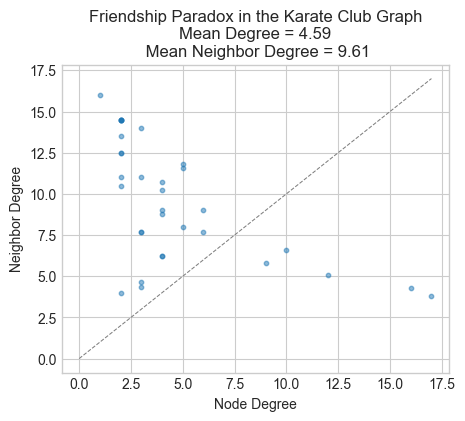

In [31]:
mean_degree = np.mean(deg_seq)
neighbor_degrees = [np.mean([deg_seq[j] for j in G_Karate.neighbors(i)]) for i in G_Karate.nodes()]

fig, ax = plt.subplots(1, 1, figsize = (5, 4))
ax.scatter(deg_seq, neighbor_degrees, s = 10, alpha = 0.5)
ax.plot([0, 17], [0, 17], color = "grey", linestyle = "--", linewidth = 0.75)
t = ax.set(xlabel = "Node Degree", ylabel = "Neighbor Degree", title = f"Friendship Paradox in the Karate Club Graph\nMean Degree = {mean_degree:.2f}\n Mean Neighbor Degree = {np.mean(neighbor_degrees):.2f}")

For most nodes (but not all), the mean degree of their neighbors is higher than their own degree. On average, the mean degree of a node in this graph is just half of the mean degree of that node's neighbors.


## References
